# Process Models and Hierarchical Modeling

In [179]:
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
az.style.use("arviz-darkgrid")

In [2]:
# Helper functions for data manipulation

def inv_logit(p):
    """Sigmoid function"""

    return np.exp(p) / (1 + np.exp(p))



def standardize(series):
    """Standardize a pandas series"""

    std_series = (series - series.mean()) / series.std()

    return std_series

## Preliminary - Data preparation

In [3]:
# df is dataset in `bart_data_lm.csv`. Each row is a trial.
df = pd.read_csv("bart_data_lm.csv")
df.head()

,participant,condition,p_burst,trial,pumps,cash,total,session,block,explosion
0,0,drunk,15,1,12,0.00,0.00,1,1,True
1,0,drunk,15,2,1,0.00,0.00,1,1,True
2,0,drunk,15,3,4,0.00,0.00,1,1,True
3,0,drunk,15,4,4,0.81,0.81,1,1,False
4,0,drunk,15,5,4,0.00,0.81,1,1,True


In [4]:
# db is the dataset aggregated over trials. Each row is a block.
# Note: creating this dataset was the Task 1 of the second project assignment.

db = (
    df.groupby(["participant", "condition", "p_burst"])
    .agg(
        {
            "total": "max",
            "pumps": ["sum", "mean"],
            "explosion": "sum",
            "session": "max",
            "block": "max",
        }
    )
    .reset_index()
)
db.columns = [
    idx[0] if idx[1] == "" else "_".join(idx) for idx in db.columns.to_flat_index()
]
db.rename(
    columns={"session_max": "session", "block_max": "block", "total_max": "total"},
    inplace=True,
)
n_participant = len(db.participant.unique())
factorize_condition = db["condition"].factorize()
db["a"] = factorize_condition[0]
a_labels = factorize_condition[1]
db["pC"] = 1 - db["explosion_sum"] / 30  # proportion of cashed
db["pE"] = db["explosion_sum"] / db["pumps_sum"]  # proportion of explosions
db["mNOP"] = standardize(db["pumps_mean"])
db["NOE"] = standardize(db["explosion_sum"])
db["TR"] = standardize(db["total"])
db["PB"] = standardize(db["p_burst"])
db["pC_s"] = standardize(db["pC"])
db["C"] = 30 - db["explosion_sum"]
db.head()

,participant,condition,p_burst,total,pumps_sum,pumps_mean,explosion_sum,session,block,a,pC,pE,mNOP,NOE,TR,PB,pC_s,C
0,0,drunk,10,12.83,226,7.533333,19,1,3,0,0.366667,0.084071,2.506399,1.079009,-0.759787,-1.220959,-1.079009,11
1,0,drunk,15,13.70,138,4.600000,17,1,1,0,0.433333,0.123188,0.440533,0.663809,-0.509520,0.000000,-0.663809,13
2,0,drunk,20,17.33,151,5.033333,23,1,2,0,0.233333,0.152318,0.745718,1.909411,0.534699,1.220959,-1.909411,7
3,0,sober,10,17.29,261,8.700000,19,3,2,1,0.366667,0.072797,3.328051,1.079009,0.523193,-1.220959,-1.079009,11
4,0,sober,15,13.05,150,5.000000,22,3,1,1,0.266667,0.146667,0.722242,1.701811,-0.696501,0.000000,-1.701811,8


In [5]:
# df_d is the dataset expanded within trials. Each row is a decision to pump.
# Note: creating this dataset was done in the Task 3 of the second project assignment.
df['decision'] = df.apply(lambda x: [np.repeat(0, x['pumps']) if x['explosion'] else np.append(np.repeat(0, x['pumps']), 1)], axis=1, result_type='expand')
df['explosion'] = df.apply(lambda x: [np.append(np.repeat(0, x['pumps'] - 1), 1) if x['explosion'] else np.repeat(0, x['pumps'] + 1)], axis=1, result_type='expand')
df['opportunity'] = df.apply(lambda x: [np.arange(len(x['decision']))], axis=1, result_type='expand')
df['c'], condition_labels = df.condition.factorize(sort=True)
df['pb'], pburst_labels = df.p_burst.factorize(sort=True)
df_d = df.explode(['explosion','decision','opportunity'], ignore_index=True)
df_d.head()

,participant,condition,p_burst,trial,pumps,cash,total,session,block,explosion,decision,opportunity,c,pb
0,0,drunk,15,1,12,0.0,0.0,1,1,0,0,0,0,1
1,0,drunk,15,1,12,0.0,0.0,1,1,0,0,1,0,1
2,0,drunk,15,1,12,0.0,0.0,1,1,0,0,2,0,1
3,0,drunk,15,1,12,0.0,0.0,1,1,0,0,3,0,1
4,0,drunk,15,1,12,0.0,0.0,1,1,0,0,4,0,1


## Part 1 - Hierarchical Linear Models

### Adaptive Regularization

In this part we'll consider the total reward for each participant. We'll try to see how hierarchical modeling can enable adaptive regularization.

$$
\begin{align*}
TR_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \alpha_{A[i]}
\\
\alpha_{j} &\sim \text{Normal}(0, 5) \qquad \text{for} \ j = 0..17
\\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$


Below we have two models, one with a weak prior and other with a strong prior.

### Part 1

I create a hierarchical version of the model given above with an adaptive prior.

#### hierarchical version of the model - centered version:

$$
\begin{align*}
TR_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\\
\mu_i &= \alpha_{A[i]}
\\
\alpha_{j} &\sim \text{Normal}(\bar \alpha, \bar \sigma) \qquad \text{for} \ j = 0..17
\\
\bar \alpha &\sim \text{Normal}(0, 5)
\\
\bar \sigma &\sim \text{Exponential}(2)
\\
\\
\sigma &\sim \text{Exponential}(\bar \lambda)
\\
\bar \lambda &\sim \text{Exponential}(1)
\\
\end{align*}
$$

In [ ]:
with pm.Model() as m3_C:

    lambda_bar = pm.Exponential('lambda_bar', 1)
    sigma = pm.Exponential('sigma', lambda_bar)

    a_bar = pm.Normal('a_bar', 0, 5)
    sigma_bar = pm.Exponential('sigma_bar', 2)
    a = pm.Normal('a', a_bar, sigma_bar, shape=n_participant)

    mu = a[db['participant']]
    TR = pm.Normal('TR', mu, sigma, observed=db['TR'])
    trace_m3_C = pm.sample()

In [ ]:
az.summary(trace_m3_C)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,0.014,0.066,-0.135,0.143,0.004,0.013,265.0,102.0,2.23
a[0],-0.072,0.195,-0.531,0.139,0.081,0.061,7.0,69.0,2.23
a[1],-0.003,0.147,-0.323,0.292,0.015,0.029,559.0,73.0,2.23
a[2],-0.069,0.189,-0.469,0.142,0.081,0.061,6.0,66.0,2.23
a[3],0.041,0.128,-0.204,0.337,0.004,0.026,1174.0,84.0,2.23
a[4],0.008,0.131,-0.256,0.315,0.004,0.025,1274.0,76.0,2.23
a[5],0.045,0.133,-0.250,0.332,0.003,0.027,1649.0,60.0,2.23
a[6],0.100,0.164,-0.158,0.470,0.048,0.035,21.0,64.0,2.23
a[7],-0.091,0.198,-0.536,0.140,0.083,0.062,7.0,80.0,2.23
a[8],0.083,0.149,-0.192,0.404,0.029,0.030,314.0,67.0,2.23


**Observe that we have a huge divergece problem. We need to try non-centered version.**

#### 3. hierarchical version of the model - non-centered version:

$$
\begin{align*}
TR_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\\
\mu_i &=  \bar \alpha + Z_{A[i]} * \bar \sigma
\\
Z_{j} &\sim \text{Normal}(0, 1) \qquad \text{for} \ j = 0..17
\\
\bar \alpha &\sim \text{Normal}(0, 5)
\\
\bar \sigma &\sim \text{Exponential}(2)
\\
\\
\sigma &\sim \text{Exponential}(\bar \lambda)
\\
\bar \lambda &\sim \text{Exponential}(1)
\\
\end{align*}
$$

In [187]:
with pm.Model() as m4_NC:

    lambda_bar = pm.Exponential('lambda_bar', 1)
    sigma = pm.Exponential('sigma', lambda_bar)

    a_bar = pm.Normal('a_bar', 0, 5)
    sigma_bar = pm.Exponential('sigma_bar', 2)
    Z = pm.Normal('Z', 0, 1, shape=n_participant)

    mu = a_bar + Z[db['participant']] * sigma_bar
    TR = pm.Normal('TR', mu, sigma, observed=db['TR'])
    trace_m4_NC = pm.sample()

In [188]:
az.summary(trace_m4_NC)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,0.002,0.089,-0.172,0.162,0.002,0.002,2462.0,1390.0,1.0
Z[0],-0.624,0.964,-2.270,1.336,0.021,0.020,2173.0,1355.0,1.0
Z[1],-0.117,0.907,-1.867,1.533,0.016,0.023,3124.0,1286.0,1.0
Z[2],-0.664,0.943,-2.430,1.048,0.019,0.017,2420.0,1404.0,1.0
Z[3],0.201,0.929,-1.510,2.018,0.016,0.022,3492.0,1630.0,1.0
Z[4],0.087,0.872,-1.556,1.749,0.015,0.021,3496.0,1502.0,1.0
Z[5],0.156,0.925,-1.551,1.946,0.018,0.025,2663.0,1268.0,1.0
Z[6],0.544,0.919,-1.205,2.251,0.020,0.016,2045.0,1673.0,1.0
Z[7],-0.723,0.928,-2.372,1.067,0.022,0.017,1809.0,1395.0,1.0
Z[8],0.443,0.919,-1.188,2.187,0.021,0.021,1967.0,1438.0,1.0


We observe that ess and r_hat values do not show much of a serious problem with the model. We didn't also have any divergences for this model. And the trace plots have a random enough pattern which further shows our model has converged relatively well.


/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (22), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'a_bar'}>,
        <Axes: title={'center': 'a_bar'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'Z\n0'}>,
        <Axes: title={'center': 'Z\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'Z\n1'}>,
        <Axes: title={'center': 'Z\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'Z\n2'}>,
        <Axes: title={'center': 'Z\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'Z\n3'}>,
        <Axes: title={'center': 'Z\n3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'Z\n4'}>,
        <Axes: title={'center': 'Z\n4'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'Z\n5'}>,
        <Axes: title={'center': 'Z\n5'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'Z\n6'}>,
        <Axes: title={'center': 'Z\n6'}, xlabel='Rank

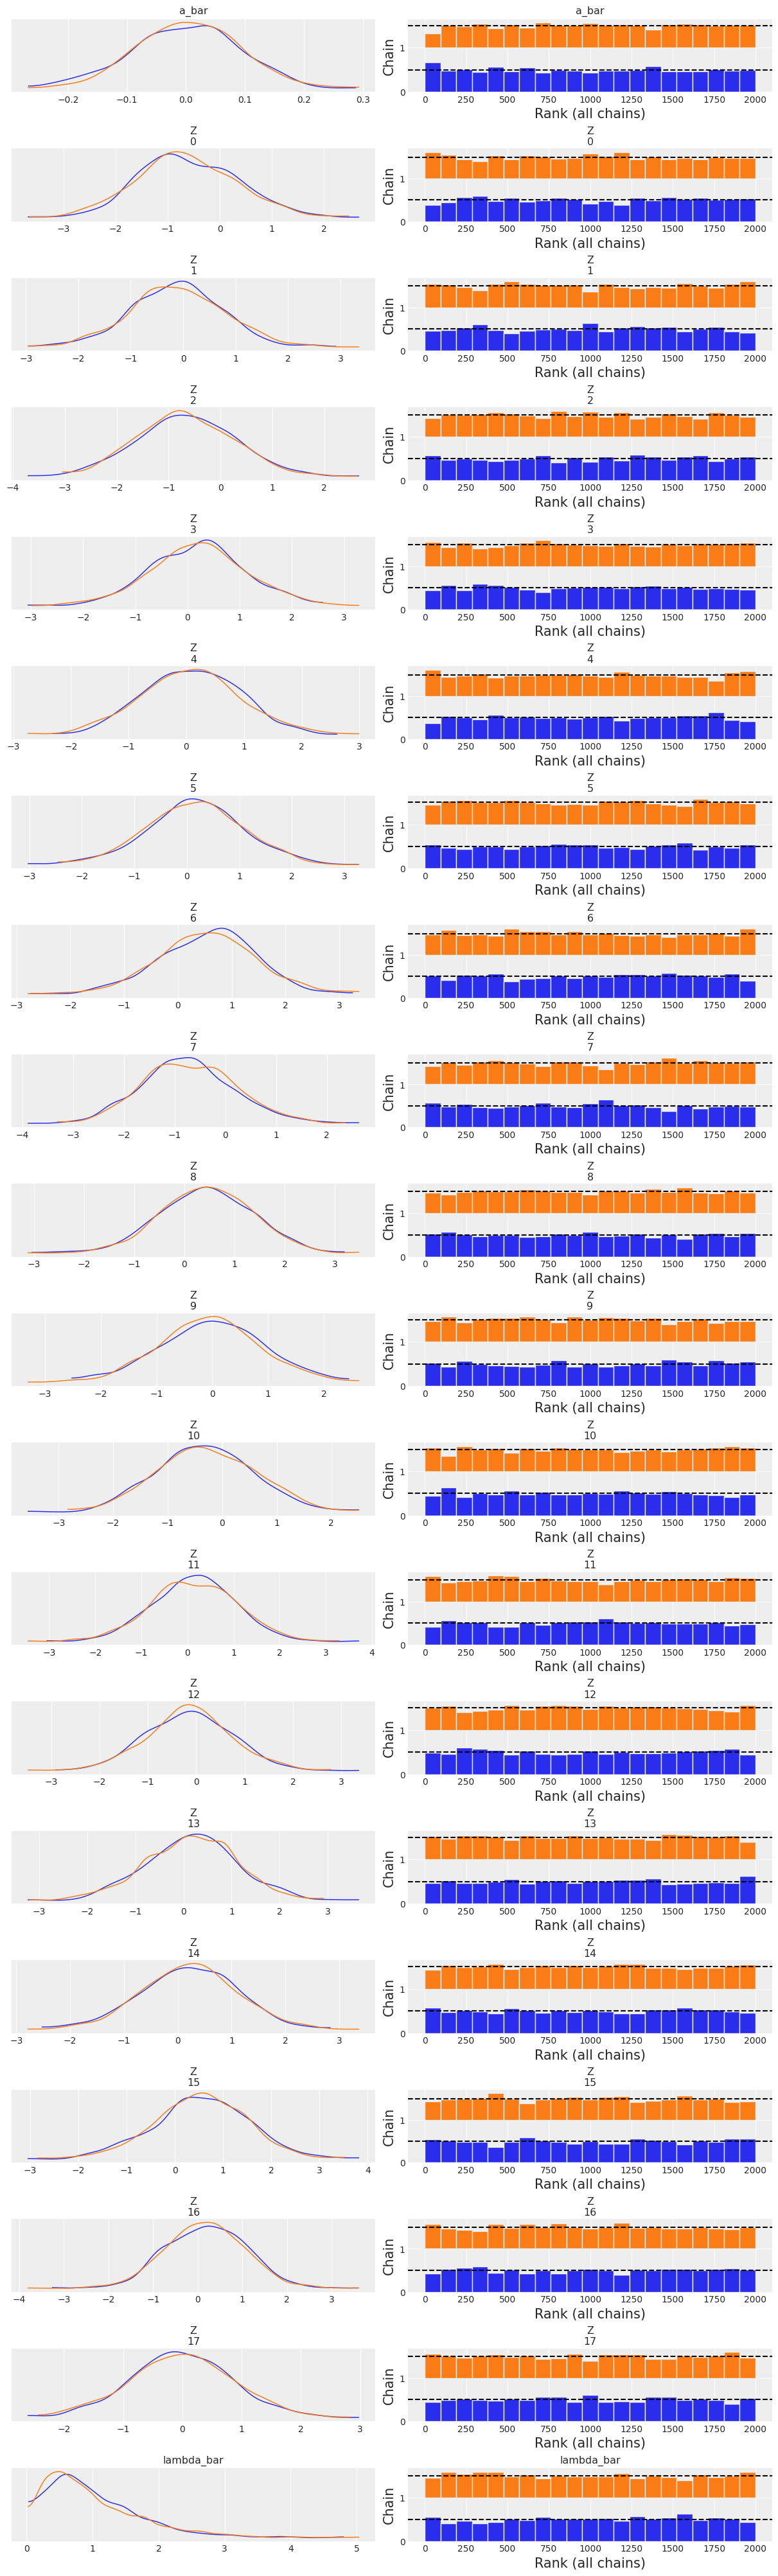

In [189]:
az.plot_trace(trace_m4_NC, kind="rank_bars", compact=False)

#### 4. Plotting our models

Below, we can observe the difference in predictions between our hierarchical and non-hierarchical model predictions.

We observe that, unlike the non-hierarchical models that either overfit or underfit the data, the hierarchical gives a much more robust result. Taking the similarity between different participants into account, the hierarchical model gives us a suitable prediction for each participant. The predictions show enough difference between different participants which means our model takes the differences into account and does not underfit. At the same time, our predictions are not overly close to the data which means our model also takes similarities into account and doesn't overfit.

In [ ]:
trace_c = trace_m3_C.posterior.a.stack(samples=('chain','draw')).to_numpy()
trace_d = (trace_m4_NC.posterior.Z * trace_m4_NC.posterior.sigma_bar + trace_m4_NC.posterior.a_bar).stack(samples=('chain','draw')).to_numpy()

<ipython-input-114-a4be304e1096>:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for key, group in db.groupby(["participant"]):
<ipython-input-114-a4be304e1096>:14: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  yerr=np.abs(az.hdi(trace_a.T, hdi_prob=0.89) - trace_a.mean(1).reshape((18, 1))).T,
<ipython-input-114-a4be304e1096>:20: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  yerr=np.abs(az.hdi(trace_b.T, hdi_prob=0.89) - trace_b.mean(1).reshape((18, 1))).T,
<ipython-input-114-a4be304e1096>:26: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future

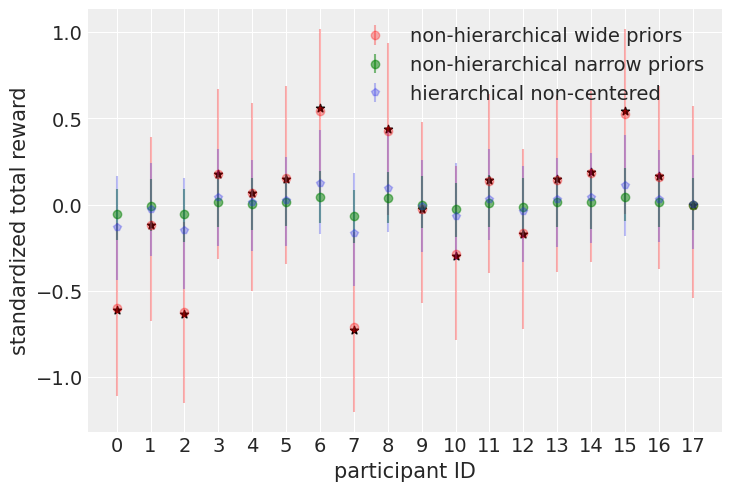

In [ ]:
# plotting all on the top of each other

fig, ax = plt.subplots()
for key, group in db.groupby(["participant"]):
    tr_mean = group["TR"].mean()
    ax.scatter(key, tr_mean, marker='*', color="k")
ax.set_xticks(db.participant.unique())
ax.set_ylabel("standardized total reward")
ax.set_xlabel("participant ID")

ax.errorbar(
    db.participant.unique(),
    trace_a.mean(1),
    yerr=np.abs(az.hdi(trace_a.T, hdi_prob=0.89) - trace_a.mean(1).reshape((18, 1))).T,
    fmt='ro', alpha=0.3, label='non-hierarchical wide priors'
)
ax.errorbar(
    db.participant.unique(),
    trace_b.mean(1),
    yerr=np.abs(az.hdi(trace_b.T, hdi_prob=0.89) - trace_b.mean(1).reshape((18, 1))).T,
    fmt='go', alpha=0.5, label='non-hierarchical narrow priors'
)
ax.errorbar(
    db.participant.unique(),
    trace_d.mean(1),
    yerr=np.abs(az.hdi(trace_d.T, hdi_prob=0.89) - trace_d.mean(1).reshape((18, 1))).T,
    fmt='p', alpha=0.3, label='hierarchical non-centered'
)

ax.legend()

plt.show()

<ipython-input-115-31cf06abd61c>:12: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  yerr=np.abs(az.hdi(trace_a.T, hdi_prob=0.89) - trace_a.mean(1).reshape((18, 1))).T,
<ipython-input-115-31cf06abd61c>:23: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  yerr=np.abs(az.hdi(trace_b.T, hdi_prob=0.89) - trace_b.mean(1).reshape((18, 1))).T,
<ipython-input-115-31cf06abd61c>:34: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  yerr=np.abs(az.hdi(trace_c.T, hdi_prob=0.89) - trace_c.mean(1).reshape((18, 1))).T,
<ipython-input-115-31cf06abd61c>:45: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, dra

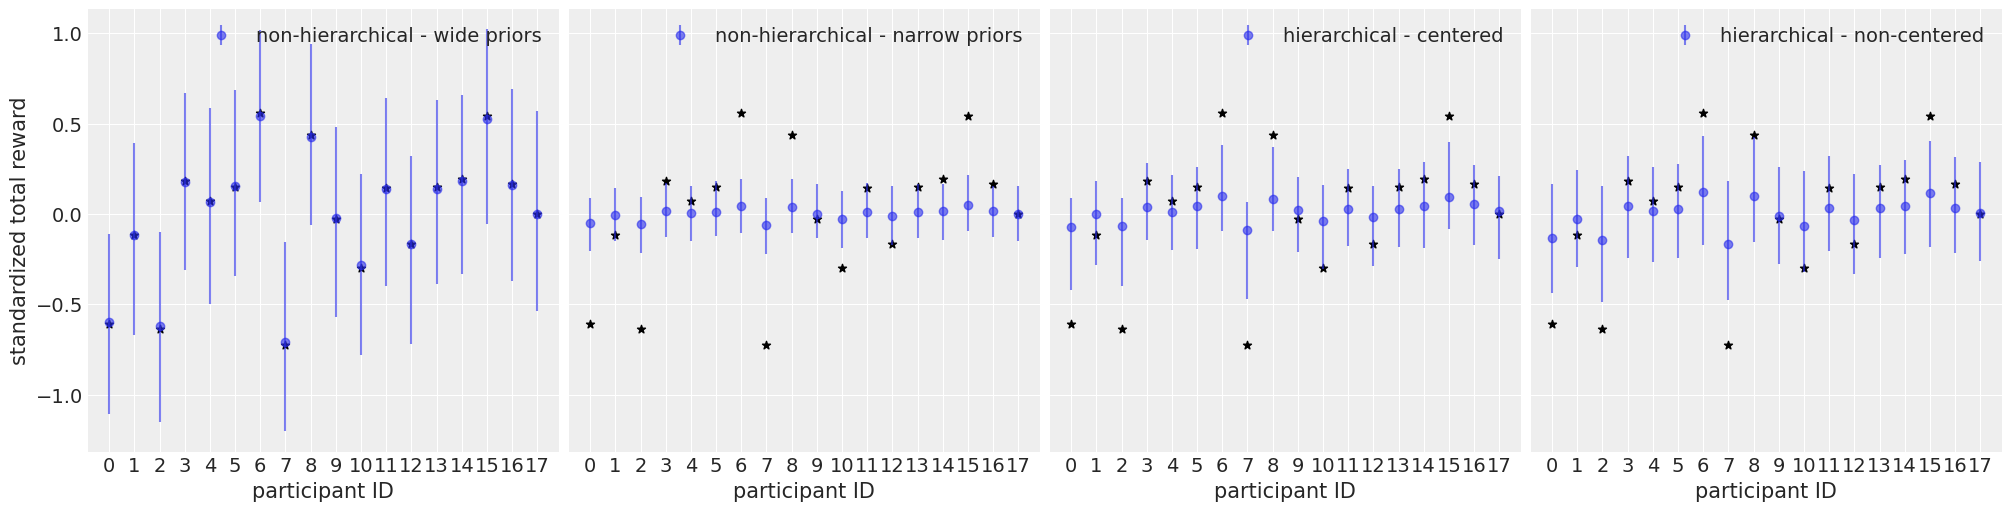

In [ ]:
# plotting them separately for increased clarity

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

axs[0].scatter(db.participant.unique(), db.groupby(["participant"])["TR"].mean(), marker='*', color="k")
axs[0].set_xticks(db.participant.unique())
axs[0].set_ylabel("standardized total reward")
axs[0].set_xlabel("participant ID")
axs[0].errorbar(
    db.participant.unique(),
    trace_a.mean(1),
    yerr=np.abs(az.hdi(trace_a.T, hdi_prob=0.89) - trace_a.mean(1).reshape((18, 1))).T,
    fmt='o', alpha=0.6, label='non-hierarchical - wide priors'
)
axs[0].legend()

axs[1].scatter(db.participant.unique(), db.groupby(["participant"])["TR"].mean(), marker='*', color="k")
axs[1].set_xticks(db.participant.unique())
axs[1].set_xlabel("participant ID")
axs[1].errorbar(
    db.participant.unique(),
    trace_b.mean(1),
    yerr=np.abs(az.hdi(trace_b.T, hdi_prob=0.89) - trace_b.mean(1).reshape((18, 1))).T,
    fmt='o', alpha=0.6, label='non-hierarchical - narrow priors'
)
axs[1].legend()

axs[2].scatter(db.participant.unique(), db.groupby(["participant"])["TR"].mean(), marker='*', color="k")
axs[2].set_xticks(db.participant.unique())
axs[2].set_xlabel("participant ID")
axs[2].errorbar(
    db.participant.unique(),
    trace_c.mean(1),
    yerr=np.abs(az.hdi(trace_c.T, hdi_prob=0.89) - trace_c.mean(1).reshape((18, 1))).T,
    fmt='o', alpha=0.6, label='hierarchical - centered'
)
axs[2].legend()

axs[3].scatter(db.participant.unique(), db.groupby(["participant"])["TR"].mean(), marker='*', color="k")
axs[3].set_xticks(db.participant.unique())
axs[3].set_xlabel("participant ID")
axs[3].errorbar(
    db.participant.unique(),
    trace_d.mean(1),
    yerr=np.abs(az.hdi(trace_d.T, hdi_prob=0.89) - trace_d.mean(1).reshape((18, 1))).T,
    fmt='o', alpha=0.6, label='hierarchical - non-centered'
)
axs[3].legend()

plt.show()

### Non-Hierarchical Bernoulli Model
This is from last part of the project, slightly changed and replicated below.

$$
\begin{align*}
D_i &\sim \text{Bernoulli}(p_i)
\\
\text{logit}(p_i) &= \alpha_{A[i]} + \beta_{B[i]} + \gamma_{T[i]} + \theta O_i
\\
\alpha_{j} &\sim \text{Normal}(0, 1) \qquad \text{for} \ j = 0..17 \text{ participants}
\\
\beta_{k} &\sim \text{Normal}(0, 1) \qquad \text{for} \ k = 0..3 \text{ blocks}
\\
\gamma_{l} &\sim \text{Normal}(0, 1) \qquad \text{for} \ l = 0..3 \text{ conditions}
\\
\theta &\sim \text{Normal}(0, 0.1)
\end{align*}
$$

Previously we treated $3*3=9$ combinations of `pburst` x `alcohol` as different treatments. Now we create a model with a separate term for:
- each participant $\alpha$
- each pburst block $\beta$
- each alcohol condition $\gamma$
- opportunity effect

In [ ]:
n_participant = len(df_d.participant.unique())
n_block = len(pburst_labels)
n_condition = len(condition_labels)
dc = df_d.decision.astype('float64').values
o = df_d.opportunity.astype('float64').values

with pm.Model() as m_GL_D:
    a = pm.Normal('a', 0, 1, shape=n_participant)
    b = pm.Normal('b', 0, 1, shape=3)
    g = pm.Normal('g', 0, 1, shape=3)
    t = pm.Normal('t', 0, 0.1)
    p = pm.Deterministic('p', pm.math.invlogit(a[df_d['participant']] + b[df_d['pb']] + g[df_d['c']] + t * o))
    D = pm.Bernoulli('D', p=p, observed=dc)

Above priors are selected after considering the prior predictive simulation below. Especially change $\sigma$ for $\theta$ to see its effect.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


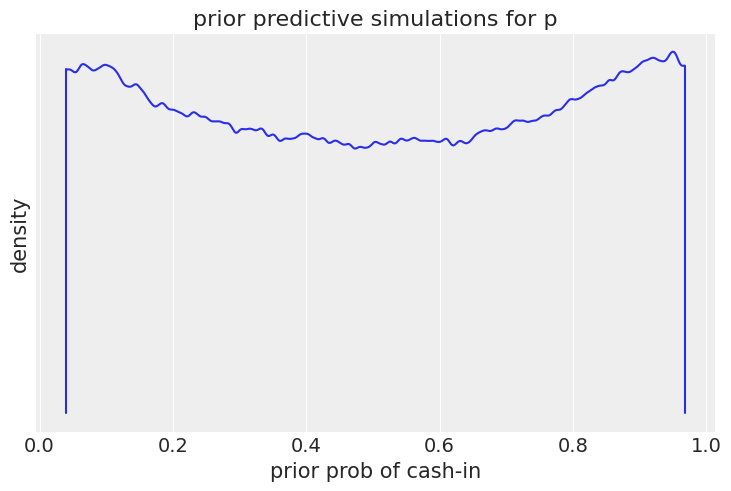

In [ ]:
with m_GL_D:
    pp = pm.sample_prior_predictive(samples=1000)

ax = az.plot_density(
    [pp.prior["p"].to_numpy().flatten()],
    data_labels=["narrow priors"],
    point_estimate=None
)
ax = ax[0]
ax[0].set_xlabel("prior prob of cash-in")
ax[0].set_ylabel("density")
ax[0].set_title("prior predictive simulations for p");

In [ ]:
with m_GL_D:
    idata_m_GL_D = pm.sample()

In [ ]:
ps = az.summary(idata_m_GL_D, var_names=['a', 'b', 'g', 't'])

Now we see a large effect of individual preferences.

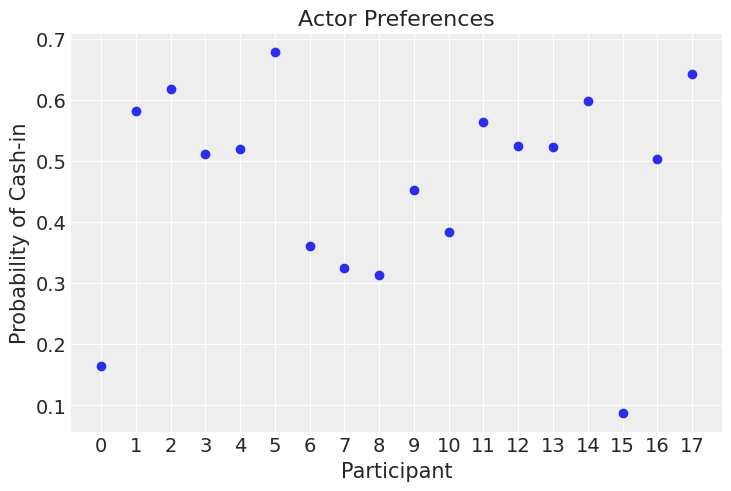

In [ ]:
plt.scatter(np.arange(18), inv_logit(ps["mean"][0:18]))
plt.xticks(np.arange(18))
plt.xlabel('Participant')
plt.ylabel('Probability of Cash-in')
plt.title('Actor Preferences');

Effects of alcohol and burst probability are given below. Note that different from the results of the model from previous assignment, these effects are independent of opportunity. We see that there's an increased tendency to cash-in for higher burst probabilities, and sober condition is when participants are most likely to cash-in.

In [ ]:
inv_logit(ps['mean'])[-7:]

b[0]    0.136343
b[1]    0.204891
b[2]    0.294007
g[0]    0.189848
g[1]    0.212989
g[2]    0.192476
t       0.569301
Name: mean, dtype: float64

(Int64Index([10, 15, 20], dtype='int64'),
 Index(['drunk', 'sober', 'tipsy'], dtype='object'))

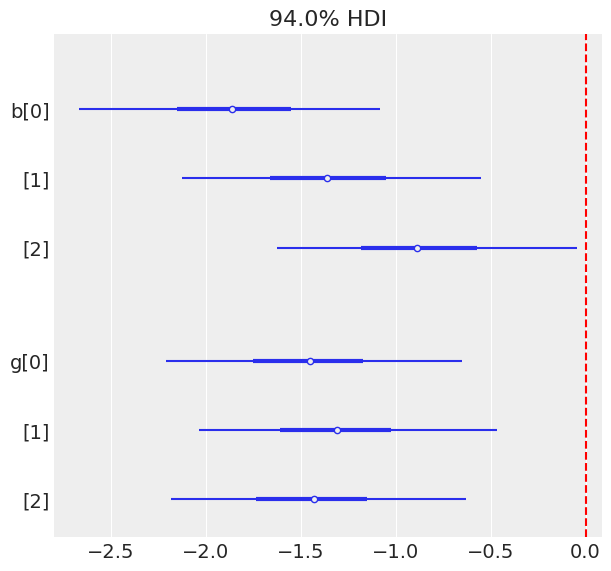

In [ ]:
az.plot_forest(idata_m_GL_D, var_names=['b', 'g'], combined=True)
plt.axvline(x=0, color='red', linestyle='--');
pburst_labels, condition_labels

The coefficient for opportunity is positive, as expected. Probability of cashing-in increases with opportunity number.

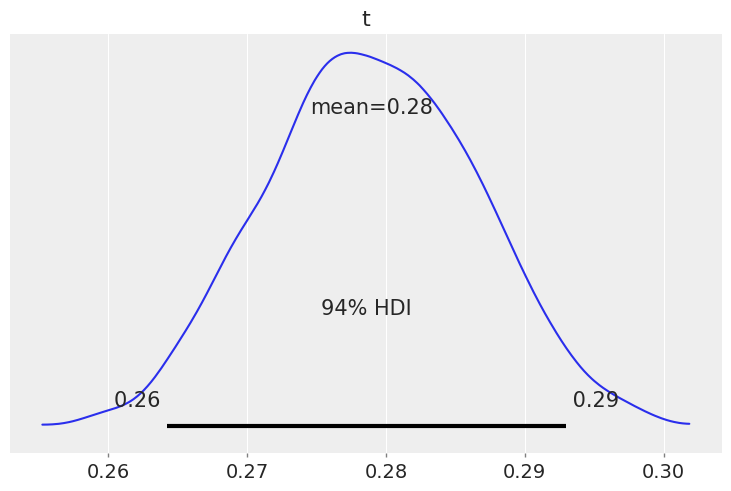

In [ ]:
az.plot_posterior(idata_m_GL_D, var_names=['t']);

### Part 2:

In this section, I assume that treatment effects vary within two clusters: participants and blocks. I create a varying effects model and discard the opportunity effect. 

In the below model, using the same notations as previous section,
- Average log-odds for each alcohol condition (treatment) is shown by $$\bar \beta_{B[i]}$$
- Effect for each participant in each condition is shown by $$\alpha_{A[i], T[i]}$$
- Effect for each block in each condition is shown by $$\beta_{B[i],T[i]}$$

$$
\begin{align*}
\\
D_i &\sim \text{Bernoulli}(p_i)
\\
\text{logit}(p_i) &= \bar \beta_{B[i]} + \alpha_{A[i], T[i]} + \beta_{ B[i],T[i]}
\\
\\
\alpha &= (\text{diag}(\pmb S_A) \pmb R_A \pmb Z_{T,A})^T
\\
\beta &= (\text{diag}(\pmb S_B) \pmb R_B \pmb Z_{T,B})^T
\\
\pmb Z_{T,A} & \sim \text{Normal}(0,1)
\\
\pmb Z_{T,B} & \sim  \text{Normal}(0,1)
\\
z_{\bar B, k} &\sim \text{Normal}(0,1)
\\
\bar \beta &= z_{\bar B, k} \tau_B
\\
S_{A,j}, S_{B,j}, \tau_B &\sim \text{Exponential}(1)
\\
\pmb R_A, \pmb R_B &\sim \text{LKJcorr}(4)
\end{align*}
$$

In [6]:
n_participant = len(df_d.participant.unique())
n_block = len(pburst_labels)
n_condition = len(condition_labels)
dc = df_d.decision.astype('float64').values
o = df_d.opportunity.astype('float64').values

with pm.Model() as m5_mBTCov_ncent:
    chol_actor, _, _ = pm.LKJCholeskyCov(
        "chol_actor", n=3, eta=3, sd_dist=pm.Exponential.dist(2.0), compute_corr=True
    )
    chol_block, _, _ = pm.LKJCholeskyCov(
        "chol_block", n=3, eta=3, sd_dist=pm.Exponential.dist(7.0), compute_corr=True
    )

    tau_B = pm.Exponential("tau_B", 1)

    z_B = pm.Normal("z_B", 0, 1, shape=n_block)

    b_bar = pm.Deterministic('b_bar', z_B * tau_B)

    z_actor = pm.Normal("z_actor", 0, 1, shape=(n_condition, n_participant))
    a = pm.Deterministic('a', pm.math.dot(chol_actor, z_actor).T)
    z_block = pm.Normal("z_block", 0, 1, shape=(n_condition, n_block))
    b = pm.Deterministic('b', pm.math.dot(chol_block, z_block).T)

    p = pm.Deterministic('p', pm.math.invlogit(
        a[df_d['participant'], df_d['c']] + b_bar[df_d['pb']] + b[df_d['pb'], df_d['c']]
    ))
    D = pm.Bernoulli("D", p=p, observed=dc)

    m5_trace_ncent = pm.sample(700, tune = 500, nuts={"target_accept": 0.9})

In the following summary table, we can check the predicted standard deviation for each of our 3 actor intercept and slopes (belonging to alpha[participant, condition]. observe each SD is around 0.45).

And for each of our 3 block intercept and slopes (belonging to beta[pBurst, condition]. Observe each SD is around 0.1). (standard deviation shows us the expected distance from the mean for every slope or intercept.)

We can also observe the correlation matrix between the triples of intercept x slope1 x slope2 for actor (alpha) and block (beta). The correlation goes from 1 (strong positive linear relation) to -1 (strong negative linear relation).

These values could be used to analyze the linear models used to construct alpha and beta.


In [13]:
az.summary(m5_trace_ncent, var_names = ['chol_actor_corr', 'chol_actor_stds', 'chol_block_corr', 'chol_block_stds'])

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"chol_actor_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,1400.0,1400.0,NaN
"chol_actor_corr[0, 1]",0.611,0.162,0.316,0.878,0.008,0.006,374.0,629.0,1.01
"chol_actor_corr[0, 2]",0.681,0.144,0.413,0.924,0.007,0.005,423.0,631.0,1.01
"chol_actor_corr[1, 0]",0.611,0.162,0.316,0.878,0.008,0.006,374.0,629.0,1.01
"chol_actor_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,1310.0,1233.0,1.00
"chol_actor_corr[1, 2]",0.435,0.186,0.100,0.784,0.007,0.005,611.0,683.0,1.00
"chol_actor_corr[2, 0]",0.681,0.144,0.413,0.924,0.007,0.005,423.0,631.0,1.01
"chol_actor_corr[2, 1]",0.435,0.186,0.100,0.784,0.007,0.005,611.0,683.0,1.00
"chol_actor_corr[2, 2]",1.000,0.000,1.000,1.000,0.000,0.000,1312.0,1301.0,1.00
chol_actor_stds[0],0.460,0.078,0.325,0.607,0.004,0.003,444.0,562.0,1.00


In addition, by the below 2 tables, we can analyze how each of our three linking function terms affects the probability of pumping for a participant.

We observe that Participant 18 when drunk and Participant 6 when sober seem to have the highest odds of pumping in terms of alcohol's effect on different participants. While, participant 16 has the smallest alcohol effect on pump decision when drunk or tipsy (this also confirms the conclusions we had regarding Participant 16 in the linear model analysis in the second part of the project assignment).

In addition, we can observe that the highest effect in terms of each pburst block and condition effects combined, the highest effects happens for the tipsy condition and pburst 0.20 combination, and for the drunk condition and pburst 0.10 combinations. In these 2 cases, the highest effect happens on the participant's decision to pump.

As for the pure effects of alcohol condition, we can observe that the highest effect belongs to the case when the condition of participants are tipsy.

In [10]:
pd.set_option('display.max_rows', None)
inv_logit(az.summary(m5_trace_ncent, var_names = ['a', 'b', 'b_bar']))['mean']

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


a[0, 0]     0.312383
a[0, 1]     0.266980
a[0, 2]     0.381544
a[1, 0]     0.600128
a[1, 1]     0.515995
a[1, 2]     0.556014
a[2, 0]     0.621519
a[2, 1]     0.645656
a[2, 2]     0.592425
a[3, 0]     0.455617
a[3, 1]     0.515495
a[3, 2]     0.544631
a[4, 0]     0.532952
a[4, 1]     0.538424
a[4, 2]     0.550576
a[5, 0]     0.641527
a[5, 1]     0.674805
a[5, 2]     0.559960
a[6, 0]     0.422627
a[6, 1]     0.434626
a[6, 2]     0.383670
a[7, 0]     0.356176
a[7, 1]     0.425069
a[7, 2]     0.336708
a[8, 0]     0.437823
a[8, 1]     0.379894
a[8, 2]     0.475021
a[9, 0]     0.466301
a[9, 1]     0.499000
a[9, 2]     0.565865
a[10, 0]    0.429473
a[10, 1]    0.431435
a[10, 2]    0.431189
a[11, 0]    0.539915
a[11, 1]    0.539666
a[11, 2]    0.549339
a[12, 0]    0.507000
a[12, 1]    0.565865
a[12, 2]    0.516244
a[13, 0]    0.523732
a[13, 1]    0.510998
a[13, 2]    0.533948
a[14, 0]    0.561684
a[14, 1]    0.631812
a[14, 2]    0.544383
a[15, 0]    0.221663
a[15, 1]    0.368188
a[15, 2]    0

In [9]:
(az.summary(m5_trace_ncent, var_names = ['a', 'b', 'b_bar']))['mean']

a[0, 0]    -0.789
a[0, 1]    -1.010
a[0, 2]    -0.483
a[1, 0]     0.406
a[1, 1]     0.064
a[1, 2]     0.225
a[2, 0]     0.496
a[2, 1]     0.600
a[2, 2]     0.374
a[3, 0]    -0.178
a[3, 1]     0.062
a[3, 2]     0.179
a[4, 0]     0.132
a[4, 1]     0.154
a[4, 2]     0.203
a[5, 0]     0.582
a[5, 1]     0.730
a[5, 2]     0.241
a[6, 0]    -0.312
a[6, 1]    -0.263
a[6, 2]    -0.474
a[7, 0]    -0.592
a[7, 1]    -0.302
a[7, 2]    -0.678
a[8, 0]    -0.250
a[8, 1]    -0.490
a[8, 2]    -0.100
a[9, 0]    -0.135
a[9, 1]    -0.004
a[9, 2]     0.265
a[10, 0]   -0.284
a[10, 1]   -0.276
a[10, 2]   -0.277
a[11, 0]    0.160
a[11, 1]    0.159
a[11, 2]    0.198
a[12, 0]    0.028
a[12, 1]    0.265
a[12, 2]    0.065
a[13, 0]    0.095
a[13, 1]    0.044
a[13, 2]    0.136
a[14, 0]    0.248
a[14, 1]    0.540
a[14, 2]    0.178
a[15, 0]   -1.256
a[15, 1]   -0.540
a[15, 2]   -1.413
a[16, 0]    0.020
a[16, 1]    0.002
a[16, 2]    0.246
a[17, 0]    0.694
a[17, 1]    0.371
a[17, 2]    0.324
b[0, 0]     0.040
b[0, 1]   

### Remember the Ravenzwaaij et al. (2011)'s BART model:

$$ \gamma^{+}: \text{Propensity for risk taking} $$
$$ \beta: \text{Behavioral consistency} $$
$$ p: \text{Burst probability}$$
$$ \omega = -\gamma^{+} \,/\,\text{log}(1-p) $$
$$ \theta_{kj} = \frac{1} {1+e^{\beta(k-\omega)}} $$
$$ d_{kj} \sim \text{Bernoulli}(\theta_{kj}) $$
Where:
- the subject is assumed to be informed about the actual burst probability, and $p$ is the belief of bursting probability for a subject, so you can take this to be the experimental burst probability
- $k$ is the number of the trial
- $j$ is the number of the opportunity
- $\omega$ is the number of pumps the subject considers optimal
- $\theta_{kj}$ is the probability that the subject decides to pump on the $j^{th}$ opportunity within the $k^{th}$ trial
- $\gamma^{+} \geq 0$; $\beta \geq 0$; $\omega \geq 0$
- $0 \leq p \leq 1$; $0 \leq \theta_{kj} \leq 1$
- $d_{kj} \in \{1,0\}$ (pump, cash-in)
- log is the natural logarithm, $ln$

>Cognitive process models propose concrete cognitive mechanisms that underlie observed behavior; therefore, a cognitive process model is a means to translate what is observed but relatively uninformative to what is unobserved and relatively informative (Ravenzwaaij et al., 2011).

### Part 3:
- Here, I select suitable priors for $\beta$ and $\gamma^+$, and implement the model in pymc for a single participant's single condition (e.g. participant 3, drunk)
  - Note that both $\beta$ and $\gamma^+$ $\geq0$.

- Using the dataset, we can infer a risk taking and a behavioral consistency parameter
- I extend the model such that there are group-level risk propensity and behavioral consistency parameters for each alcohol condition. Again I consider the same participant, but all of the alcohol conditions.

**The way to interpret the model parameters below and comparison with other measures**

In general, the parameters, γ+ and β, provide a nuanced understanding of decision-making in BART. The risk-taking propensity shows us a participant's inherent inclination towards risk, where higher values suggest a greater chance to take risks in each decision.

On the other hand, behavioral consistency shows the degree of stability in decision-making across trials, with higher values indicating more consistent behavior in the decisions of participants. And, according to Ravenzwaaij et al. (2011), as β → ∞, Decision Maker's behavior is completely determined by whether or not the pump opportunity exceeds the number of pumps that Decision Maker considers optimal.

These parameters provide us a more detailed characterization of the cognitive processes underlying BART performance compared to more simple measures like the number of pumps.

While the number of pumps and some of the other simple measures we have been using in this project provide us with great quantitative info and allow us to analyze many details, γ+ and β give us valuable informationfrom a different angle: they give us insights into the underlying cognitive process of participants, allowing for a more robust way to interpret decision-making of participants in BART.

**In the following models,**
- I will take 2 Exponential priors for the first model as follows:
$$ \beta \sim \text{Exponential}(1) $$
$$ \gamma^{+} \sim \text{Exponential}(1) $$
- I will construct a hierarchical model for the 2nd model, to model the similarities between different conditions properly. For this purpose, I will take exponential priors for the 2 main parameters, and I take Uniform priors for the lambda priors of each Exponential distribution:
$$ \beta_i \sim \text{Exponential}(\lambda_1) $$
$$ \gamma^{+}_j \sim \text{Exponential}(\lambda_2) $$
$$ \lambda_1, \lambda_2 \sim \text{Uniform}(0, 10) $$



In [14]:
# Data for Participant 3, drunk
df_d3 = df_d[(df_d['participant']==3) & (df_d['condition']=='drunk')]
df_d3.head()

,participant,condition,p_burst,trial,pumps,cash,total,session,block,explosion,decision,opportunity,c,pb
3955,3,drunk,20,1,4,0.0,0.0,2,1,0,0,0,0,2
3956,3,drunk,20,1,4,0.0,0.0,2,1,0,0,1,0,2
3957,3,drunk,20,1,4,0.0,0.0,2,1,0,0,2,0,2
3958,3,drunk,20,1,4,0.0,0.0,2,1,1,0,3,0,2
3959,3,drunk,20,2,2,0.0,0.0,2,1,0,0,0,0,2


In [190]:
with pm.Model() as m6_p_c:

  trial = pm.MutableData("trial", df_d3['trial'])
  PB = pm.MutableData("PB", df_d3['p_burst']/100)

  gamma_plus = pm.Exponential('gamma_plus', 1)
  beta = pm.Exponential('beta', 1)

  omega = pm.Deterministic(name="omega", var=-gamma_plus / pm.math.log(1-PB))

  theta = 1 / (1+ pm.math.exp(beta * (trial - omega)))

  decision = pm.Bernoulli('decision', p=theta, observed=df_d3['decision'])

  m6_trace = pm.sample(2000)

We observe that the predicted γ+ has a small HDI lower and upper bound. This shows that Participant 3 in a drunk condition seems to have a low propensity for risk-taking.

In addition, β also has a relatively small value. This shows that Participant 3's behavior is not affected by whether or not the pump opportunity exceeds the number of pumps that participant 3 considers optimal.

In [191]:
az.summary(m6_trace, var_names=['gamma_plus', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma_plus,0.028,0.027,0.000,0.079,0.001,0.0,1941.0,1538.0,1.0
beta,0.137,0.013,0.113,0.160,0.000,0.0,2276.0,2030.0,1.0


Also, note that ess and r_hat values do not show any serious problems with the model. The trace plots also seem to have a random enough shape without much patterns which means our sampling algorithm has converged.

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (420), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'gamma_plus'}>,
        <Axes: title={'center': 'gamma_plus'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'omega\n0'}>,
        <Axes: title={'center': 'omega\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'omega\n1'}>,
        <Axes: title={'center': 'omega\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'omega\n2'}>,
        <Axes: title={'center': 'omega\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'omega\n3'}>,
        <Axes: title={'center': 'omega\n3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'omega\n4'}>,
        <Axes: title={'center': 'omega\n4'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'omega\n5'}>,

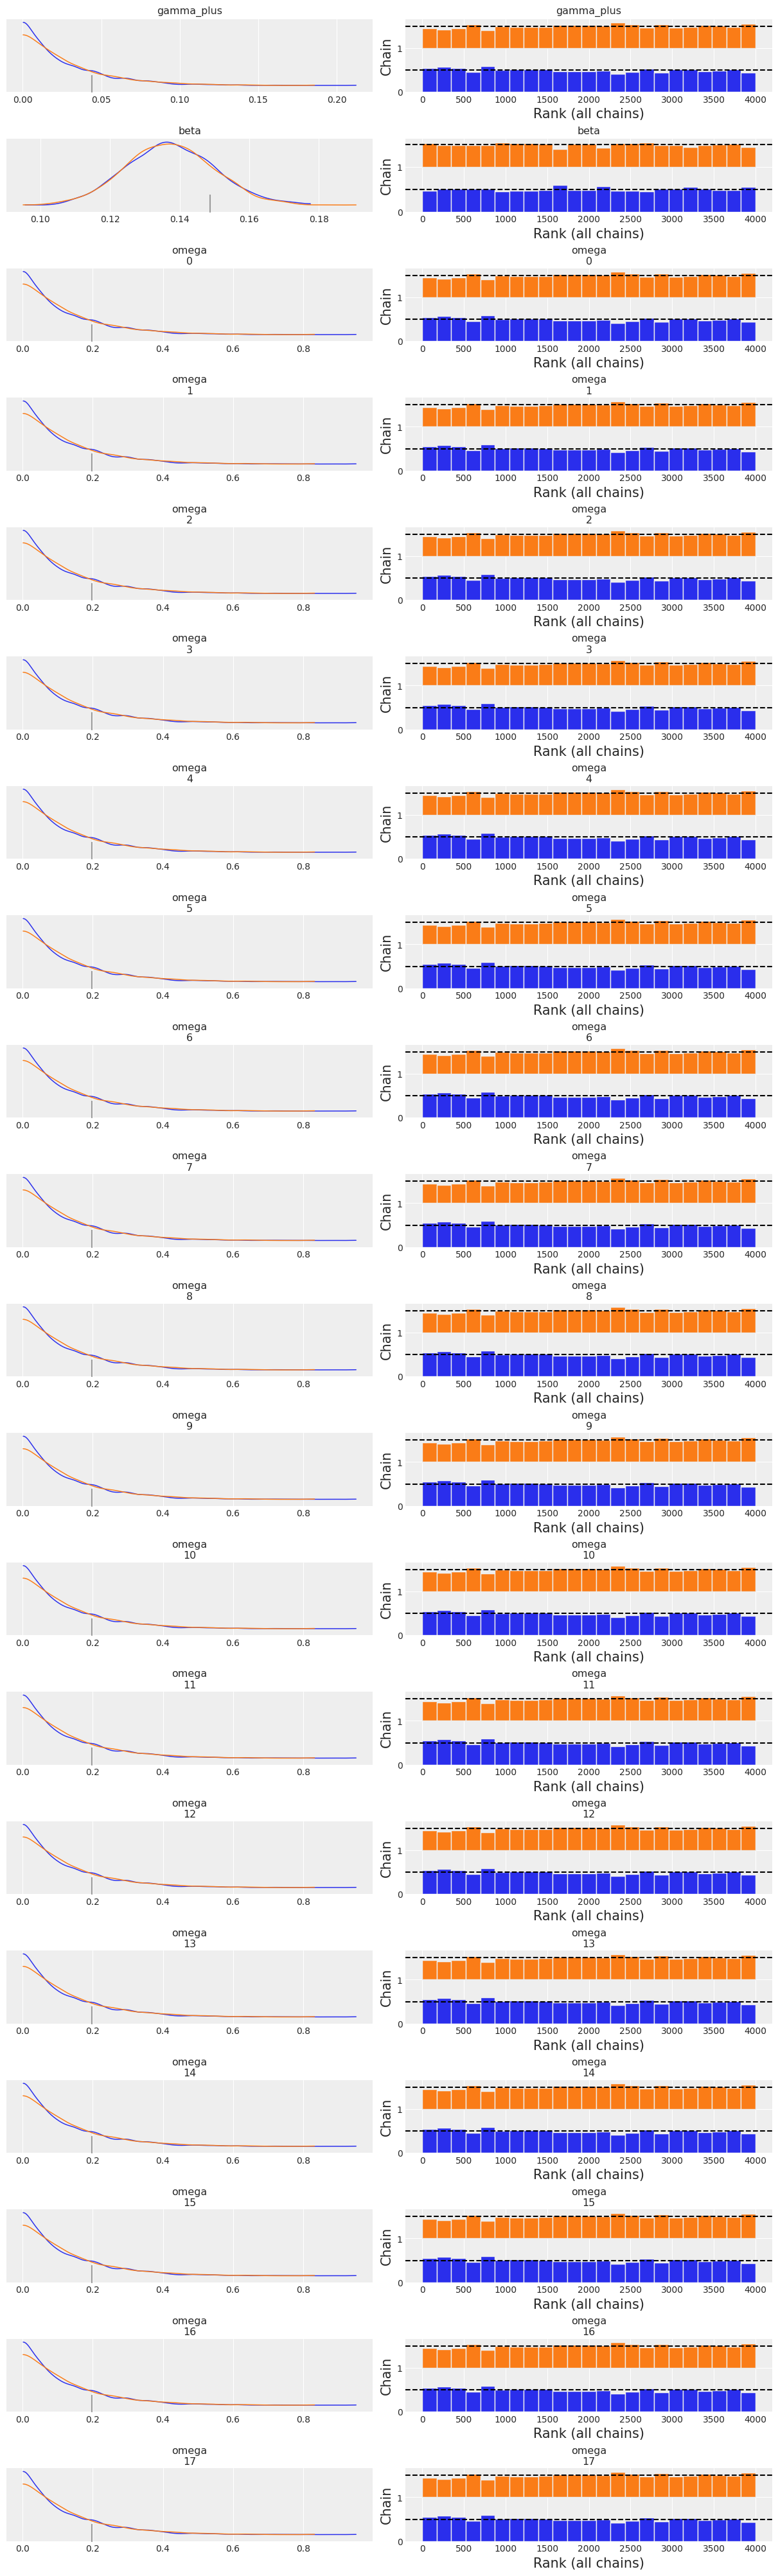

In [192]:
az.plot_trace(m6_trace, kind="rank_bars", compact=False)

In [58]:
# Data for Participant 3
df_d4 = df_d[(df_d['participant']==3)]
df_d4.head()

,participant,condition,p_burst,trial,pumps,cash,total,session,block,explosion,decision,opportunity,c,pb
3562,3,tipsy,15,1,3,0.69,0.69,1,1,0,0,0,2,1
3563,3,tipsy,15,1,3,0.69,0.69,1,1,0,0,1,2,1
3564,3,tipsy,15,1,3,0.69,0.69,1,1,0,0,2,2,1
3565,3,tipsy,15,1,3,0.69,0.69,1,1,0,1,3,2,1
3566,3,tipsy,15,2,3,0.69,1.38,1,1,0,0,0,2,1


In [64]:
n_condition = len(condition_labels)

with pm.Model() as m7_c:

  condition = pm.MutableData("condition", df_d4['c'])
  trial = pm.MutableData("trial", df_d4['trial'])
  PB = pm.MutableData("PB", df_d4['p_burst']/100)

  lambda1 = pm.Uniform('lambda1', 0, 10)
  gamma_plus = pm.Exponential('gamma_plus', lambda1, shape = n_condition)
  lambda2 = pm.Uniform('lambda2', 0, 10)
  beta = pm.Exponential('beta', lambda2, shape = n_condition)

  omega = pm.Deterministic(name="omega", var=-gamma_plus[condition] / pm.math.log(1-PB))

  theta = 1 / (1+ pm.math.exp(beta[condition] * (trial - omega)))
  decision = pm.Bernoulli('decision', p=theta, observed=df_d4['decision'])

  m7_trace = pm.sample()

In the below table, we can observe that β and γ+ both seem to have small values, which is similar to the previous model's results.

In addition, here we can observe that the highest predicted β (and lowest predicted γ+) for participant 3 seems to happen (insignificantly) when participant 3 is drunk. This means that, although the results are not that significant when Participant 3 is drunk, his/her behavior seems to be more affected by whether or not the pump opportunity exceeds the number of pumps that the participant considers optimal. And participant 3 would take fewer risks when drunk.

It is worth mentioning that, similar to the results discussed by Ravenzwaaij et al. (2011) in their paper, we can observe a negative correlation between β and γ+ here. This shows that Behavioral consistency and Propensity for risk-taking seem to have a negative relation for participant 3, similar to the paper's results.

In [155]:
az.summary(m7_trace, var_names=['lambda1', 'lambda2', 'gamma_plus', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda1,7.728,1.773,4.433,9.999,0.033,0.024,2468.0,1269.0,1.0
lambda2,6.869,2.021,3.414,9.997,0.040,0.030,2318.0,1020.0,1.0
gamma_plus[0],0.025,0.026,0.000,0.072,0.001,0.000,1778.0,1066.0,1.0
gamma_plus[1],0.035,0.033,0.000,0.099,0.001,0.001,2222.0,1217.0,1.0
gamma_plus[2],0.037,0.037,0.000,0.104,0.001,0.001,1552.0,997.0,1.0
beta[0],0.136,0.013,0.114,0.161,0.000,0.000,2232.0,1367.0,1.0
beta[1],0.095,0.009,0.079,0.112,0.000,0.000,2881.0,1223.0,1.0
beta[2],0.093,0.009,0.075,0.108,0.000,0.000,2618.0,1382.0,1.0


Note that ess and r_hat values do not show any serious problems with the model. The trace plots also seem to have a random enough shape without much patterns. So, our sampling algorithm seems to have converged suitably.

We can observe that beta posteriors have a normal shape. While gamma posteriors have a decreasing probability as we go further from their HDI region (similar to specific forms of beta distribution). Our Predicted lambda parameters also seem to have an increasing probability for higher values in its posterior. Similar to specific parameterizations of the gamma distribution.

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (1230), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'lambda1'}>,
        <Axes: title={'center': 'lambda1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'gamma_plus\n0'}>,
        <Axes: title={'center': 'gamma_plus\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'gamma_plus\n1'}>,
        <Axes: title={'center': 'gamma_plus\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'gamma_plus\n2'}>,
        <Axes: title={'center': 'gamma_plus\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'lambda2'}>,
        <Axes: title={'center': 'lambda2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: titl

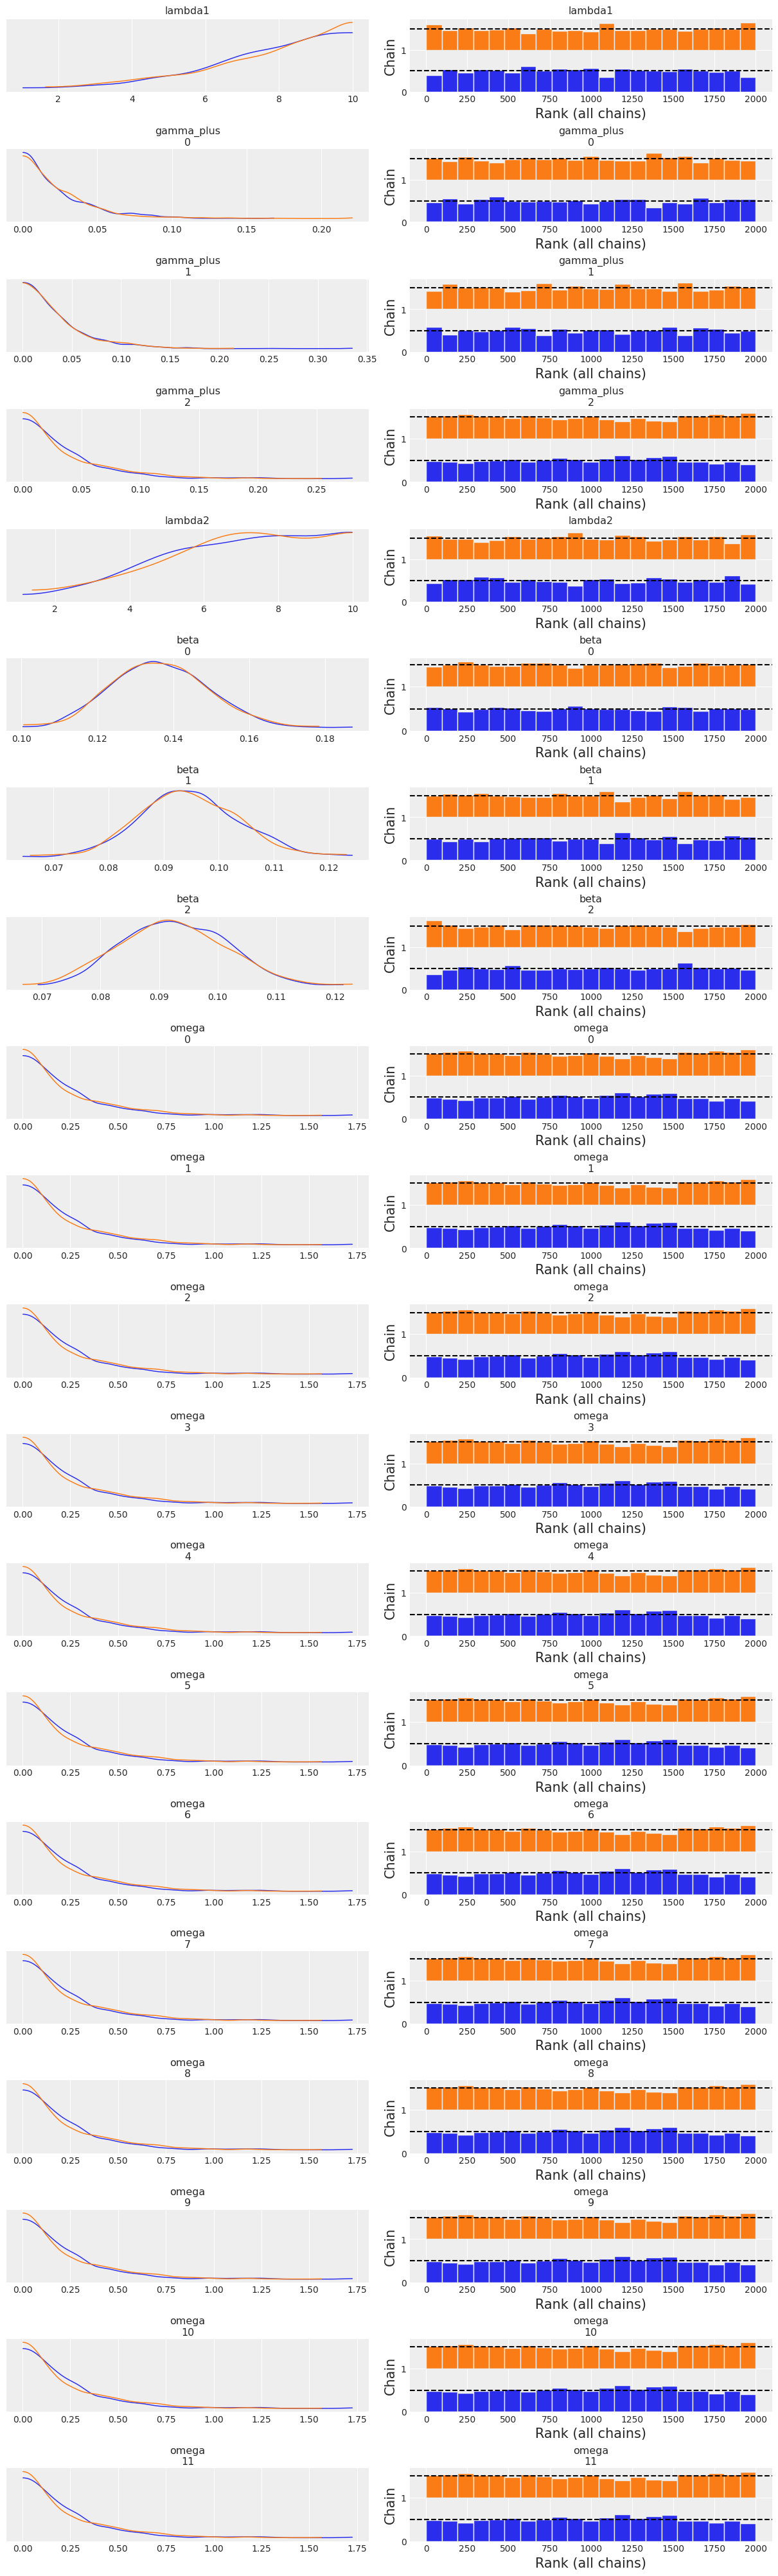

In [157]:
az.plot_trace(m7_trace, kind="rank_bars", compact=False)

array([[<Axes: title={'center': 'lambda1'}>,
        <Axes: title={'center': 'lambda2'}>,
        <Axes: title={'center': 'gamma_plus\n0'}>,
        <Axes: title={'center': 'gamma_plus\n1'}>],
       [<Axes: title={'center': 'gamma_plus\n2'}>,
        <Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>]], dtype=object)

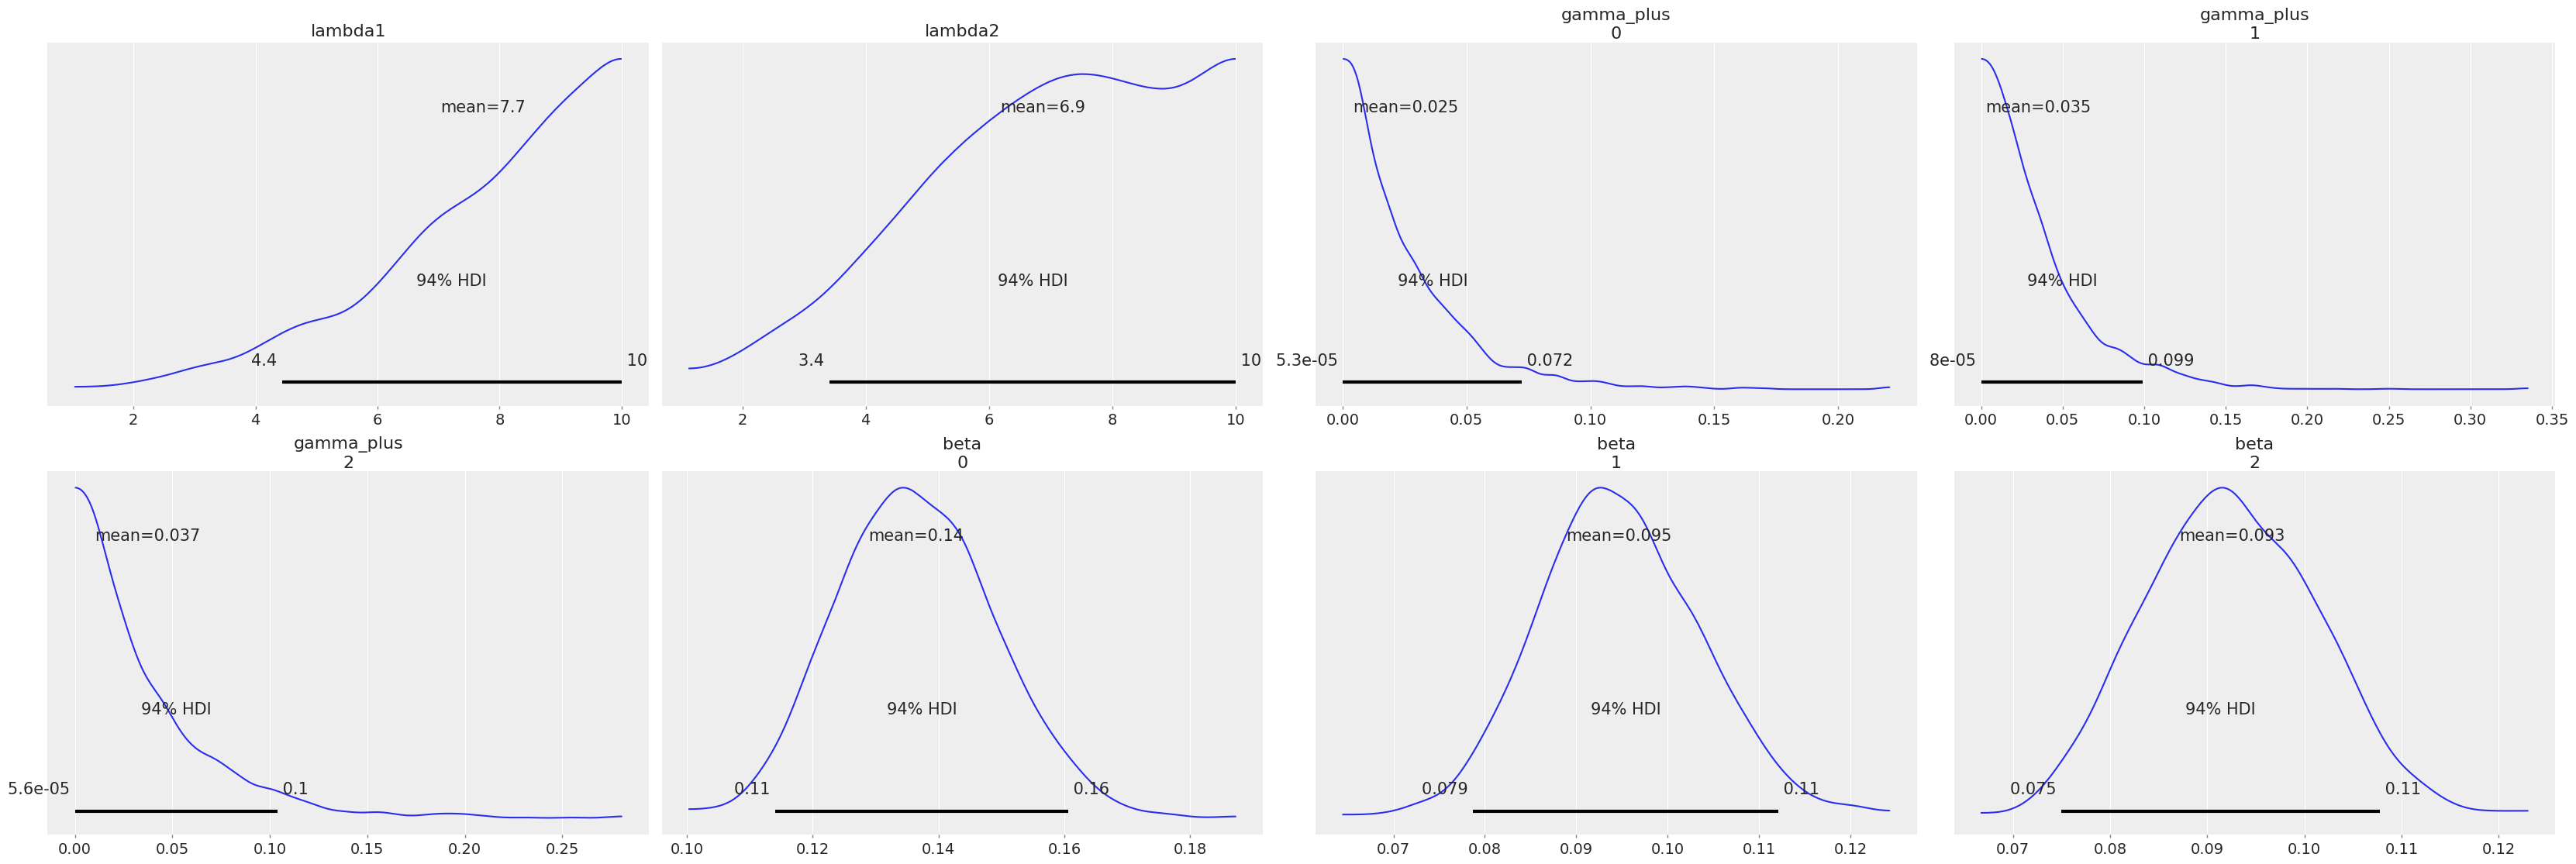

In [178]:
az.plot_posterior(m7_trace, var_names=['lambda1', 'lambda2', 'gamma_plus', 'beta'])

## Part 4

Here, I again adapt this 2nd Bart paper to my dataset:

Zeng, Xinglin, et al. (2023) Behavioral modeling and neuroimaging of impaired risky decision making in patients with chronic musculoskeletal pain, Neurophotonics.

**Below, I explain the details of a modified version of the 4-parameter I discussed in the first project assignment.**

**The model is almost identical to the version I discussed before, but I made some small changes in the notations so that the model looks more straightforward (more similar to the df_d5 dataset variables that I created below). I also made changes to the likelihood.**

**Also, I modified some of the model's indexes and added the effect of the 'condition' variable. because the experiment was done in a different manner in the paper, some of the indexes needed to be modified a little, to be more suitable for our dataset. (in the paper, the focus was more on indexing over different trials. And the paper also analyzed the effects of chronic musculoskeletal pain and I wasn't able to replicate the data. So I changed the model indexes so that it would focus on differences y the participants' change in drunk, tipsy, and sober conditions.)**

**I also decided on suitable priors for the parameters. I used a hierarchical structure for better modeling of exponential distributions.**

**In addition, similar to the previous task, I trained the model only for 1 random participant (participant 3) to avoid complications.**

[The paper available here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10194091/)

Parameters:
$$
\gamma: \text{Propensity for risk taking}
\\
\phi: \text{Prior belief of the balloon not bursting}
\\
\eta: \text{Learning rates based on the results of each trial}
\\
\tau: \text{Inverse temperature quantifying the degree of determination of choices}
$$

---

Parameter priors:
$$
\phi_e  \sim \text{Uniform}(0, 1)
\\
\gamma_f \sim \text{Exponential}(\lambda_2)
\\
\eta_g \sim \text{Exponential}(\lambda_1)
\\
\tau_h  \sim \text{Exponential}(\lambda_3)
\\
\lambda_2  \sim \text{Uniform}(0, 10)
\\
\lambda_1, \lambda_3   \sim \text{Uniform}(0, 20)
$$


---


The model:
$$
{p}^{\text{burst}}_c = 1 - \frac{\phi_c + \eta_c * pumps_{successful}}{1 + \eta_c * pumps_{total}} \; \; where: \; 0 < \phi < 1 \; , \; \eta > 0
\\
\omega_c = \frac{-\gamma_c }{\ln(1 - {p}^{\text{burst}}_c)} \; \; where: \; \gamma \geq 0
\\
{p}^{\text{pump}}_{cl} = \frac{1}{1 + e^{\tau_c(l-\omega_c)}} \; \; where: \; \tau \geq 0
\\
d_k \sim \text{Bernoulli}({p}^{\text{pump}}_{cl})
$$



[The paper available here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10194091/)


**Details of the modified version of the model:**
1.
   - Participants are assumed to renew their belief about the balloon's explosion probability in each condition.
   - The probability that participants believe a pumping would result in the balloon explosion in condition $c$ is denoted as $p^{burst}_c$.
   - Participants update prior beliefs on each condition using the above formula ${p}^{\text{burst}}_c$
   - In the model:
    + $\eta_c * pumps_{successful_c}$ refers to the sum of successful pumps for each participant, in each condition.  After each decision that the participant makes. (in the paper, this was also analyzed over different trials. The implementation is similar to my model but the index would be different. I used condition because it would be more suitable for our data. It doesn't seem logical to model different trials for each participant while ignoring the condition of the participant.)

    + $\eta_c * pumps_{total_c}$ refers to the sum of total pumps for each participant, in each condition. After each decision that the participant makes.

      - In the paper,
  $\eta \sum_{i=0}^{k} \text{n}^{\text{success}}_i$ and $\eta \sum_{i=0}^{k} \text{n}^{pumps}_i$ were used instead. Where they refer to the sum of successful pumps and total pumps when participants are making their decisions in the kth trial.

**General Details:**
- The subject is assumed to be informed about the actual burst probability, and $p^{burst}$ is the belief of bursting probability for a subject.
- $k$ is the number of the trial.
- $l$ is the number of the pump within a trial.
- $p^{burst}_c$ is the constant probability that participants believe a pumping would result in the balloon explosion in different conditions.
- $\omega_c$ is the optimal pump number determined prior to each condition.
- ${p}^{\text{pump}}_{cl}$ is the likelihood that participants can pump the balloon on condition c for pump $l$.
- $d_k \in \{1, 0\}$ (pump, cash-in)
- $ln$ is the natural logarithm.


### **Generating suitable dataset variables for the model:**

In [84]:
df_d5 = df_d

df_d5['successful_pumps'] = (
    df_d5.groupby(['participant', 'condition'])
    .apply(lambda group: (group['explosion'] == 0).astype(int).cumsum())
    .reset_index(level=[0, 1], drop=True)
    .values - 1
)  # the number of successful pumps of each participant in each condition after each decision
df_d5['pumps_total'] = (
    df_d5.groupby(['participant', 'condition'])
    .apply(lambda group: (group['explosion']>-1).astype(int).cumsum())
    .reset_index(level=[0, 1], drop=True)
    .values - 1
)  # the number of pumps of each participant in each condition after each decision

df_d5 = df_d5[(df_d['participant']==3)] # filter for participant 3 only

df_d5 = df_d5[['participant', 'condition', 'p_burst', 'trial', 'decision', 'opportunity', 'c', 'successful_pumps', 'pumps_total']]

df_d5.head()

,participant,condition,p_burst,trial,decision,opportunity,c,successful_pumps,pumps_total
3562,3,tipsy,15,1,0,0,2,0,0
3563,3,tipsy,15,1,0,1,2,1,1
3564,3,tipsy,15,1,0,2,2,2,2
3565,3,tipsy,15,1,1,3,2,2,3
3566,3,tipsy,15,2,0,0,2,3,4


### The model

In [167]:
n_condition = len(condition_labels)

with pm.Model() as m8_paper_modified_model:

  condition = pm.MutableData("condition", df_d5['c'])
  trial = pm.MutableData("trial", df_d5['trial'])
  successful_pumps = pm.MutableData("successful_pumps", df_d5['successful_pumps'])
  pumps_total = pm.MutableData("pumps_total", df_d5['pumps_total'])

  lambda1 = pm.Uniform('lambda1', 0, 20)
  lambda2 = pm.Uniform('lambda2', 0, 10)
  lambda3 = pm.Uniform('lambda3', 0, 20)

  gamma = pm.Exponential('gamma', lambda1, shape = n_condition)
  eta = pm.Exponential('eta', lambda2, shape = n_condition)
  tau = pm.Exponential('tau', lambda3, shape=n_condition)
  phi = pm.Uniform('phi', 0, 1, shape = n_condition)

  p_burst = 1 - ((phi[condition] + eta[condition] * successful_pumps) / (1 + eta[condition] * pumps_total))
  omega = -gamma[condition] / pm.math.log(1-p_burst)
  theta = 1 / (1+ pm.math.exp(tau[condition] * (trial - omega)))

  decision = pm.Bernoulli('decision', p=theta, observed=df_d5['decision'])

  m8_trace = pm.sample(2500, tune=1500, nuts={"target_accept": 0.9})

In the following summary table, we can observe that,

- $\gamma$ and $\phi$ are the lowest when drunk, meaning that the Propensity for risk-taking of participant 3 is at its lowest when they are drunk. And participant 3 has a low prior belief of the balloon not bursting when they are drunk.

- $\eta$ is highest when Participant 3 is tipsy. Meaning that the learning rate from the results of previous trials is the highest when Participant 3 is tipsy.

- $\tau$ is at its highest when Participant 3 is drunk. This means that participant 3 has a higher degree of determination of choices when they are drunk. In comparison, when they are tipsy or sober, they show more doubt when they make their choices. This also does seem logical.


In [168]:
az.summary(m8_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda1,14.889,3.878,7.831,19.998,0.048,0.035,5127.0,2394.0,1.0
lambda2,5.526,2.769,1.018,9.998,0.047,0.034,3130.0,2489.0,1.0
lambda3,10.815,4.408,3.636,19.223,0.060,0.052,4935.0,2062.0,1.0
gamma[0],0.021,0.024,0.000,0.061,0.000,0.000,3461.0,1879.0,1.0
gamma[1],0.029,0.033,0.000,0.086,0.000,0.000,4397.0,2209.0,1.0
gamma[2],0.038,0.042,0.000,0.109,0.001,0.000,4149.0,2464.0,1.0
eta[0],0.343,1.234,0.000,0.962,0.024,0.017,3036.0,2794.0,1.0
eta[1],0.332,0.967,0.000,0.980,0.020,0.014,3327.0,2939.0,1.0
eta[2],0.350,1.137,0.000,1.042,0.025,0.018,3023.0,2741.0,1.0
tau[0],0.135,0.013,0.112,0.159,0.000,0.000,6607.0,3266.0,1.0


We could also observe that ess and r_hat values do not show any serious problems with the model. The trace plots also have a random shape without any patterns which further shows our model has converged suitably.

array([[<Axes: title={'center': 'lambda1'}>,
        <Axes: title={'center': 'lambda1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'lambda2'}>,
        <Axes: title={'center': 'lambda2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'lambda3'}>,
        <Axes: title={'center': 'lambda3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'gamma\n0'}>,
        <Axes: title={'center': 'gamma\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'gamma\n1'}>,
        <Axes: title={'center': 'gamma\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'gamma\n2'}>,
        <Axes: title={'center': 'gamma\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'eta\n0'}>,
        <Axes: title={'center': 'eta\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'eta\n1'}>,
       

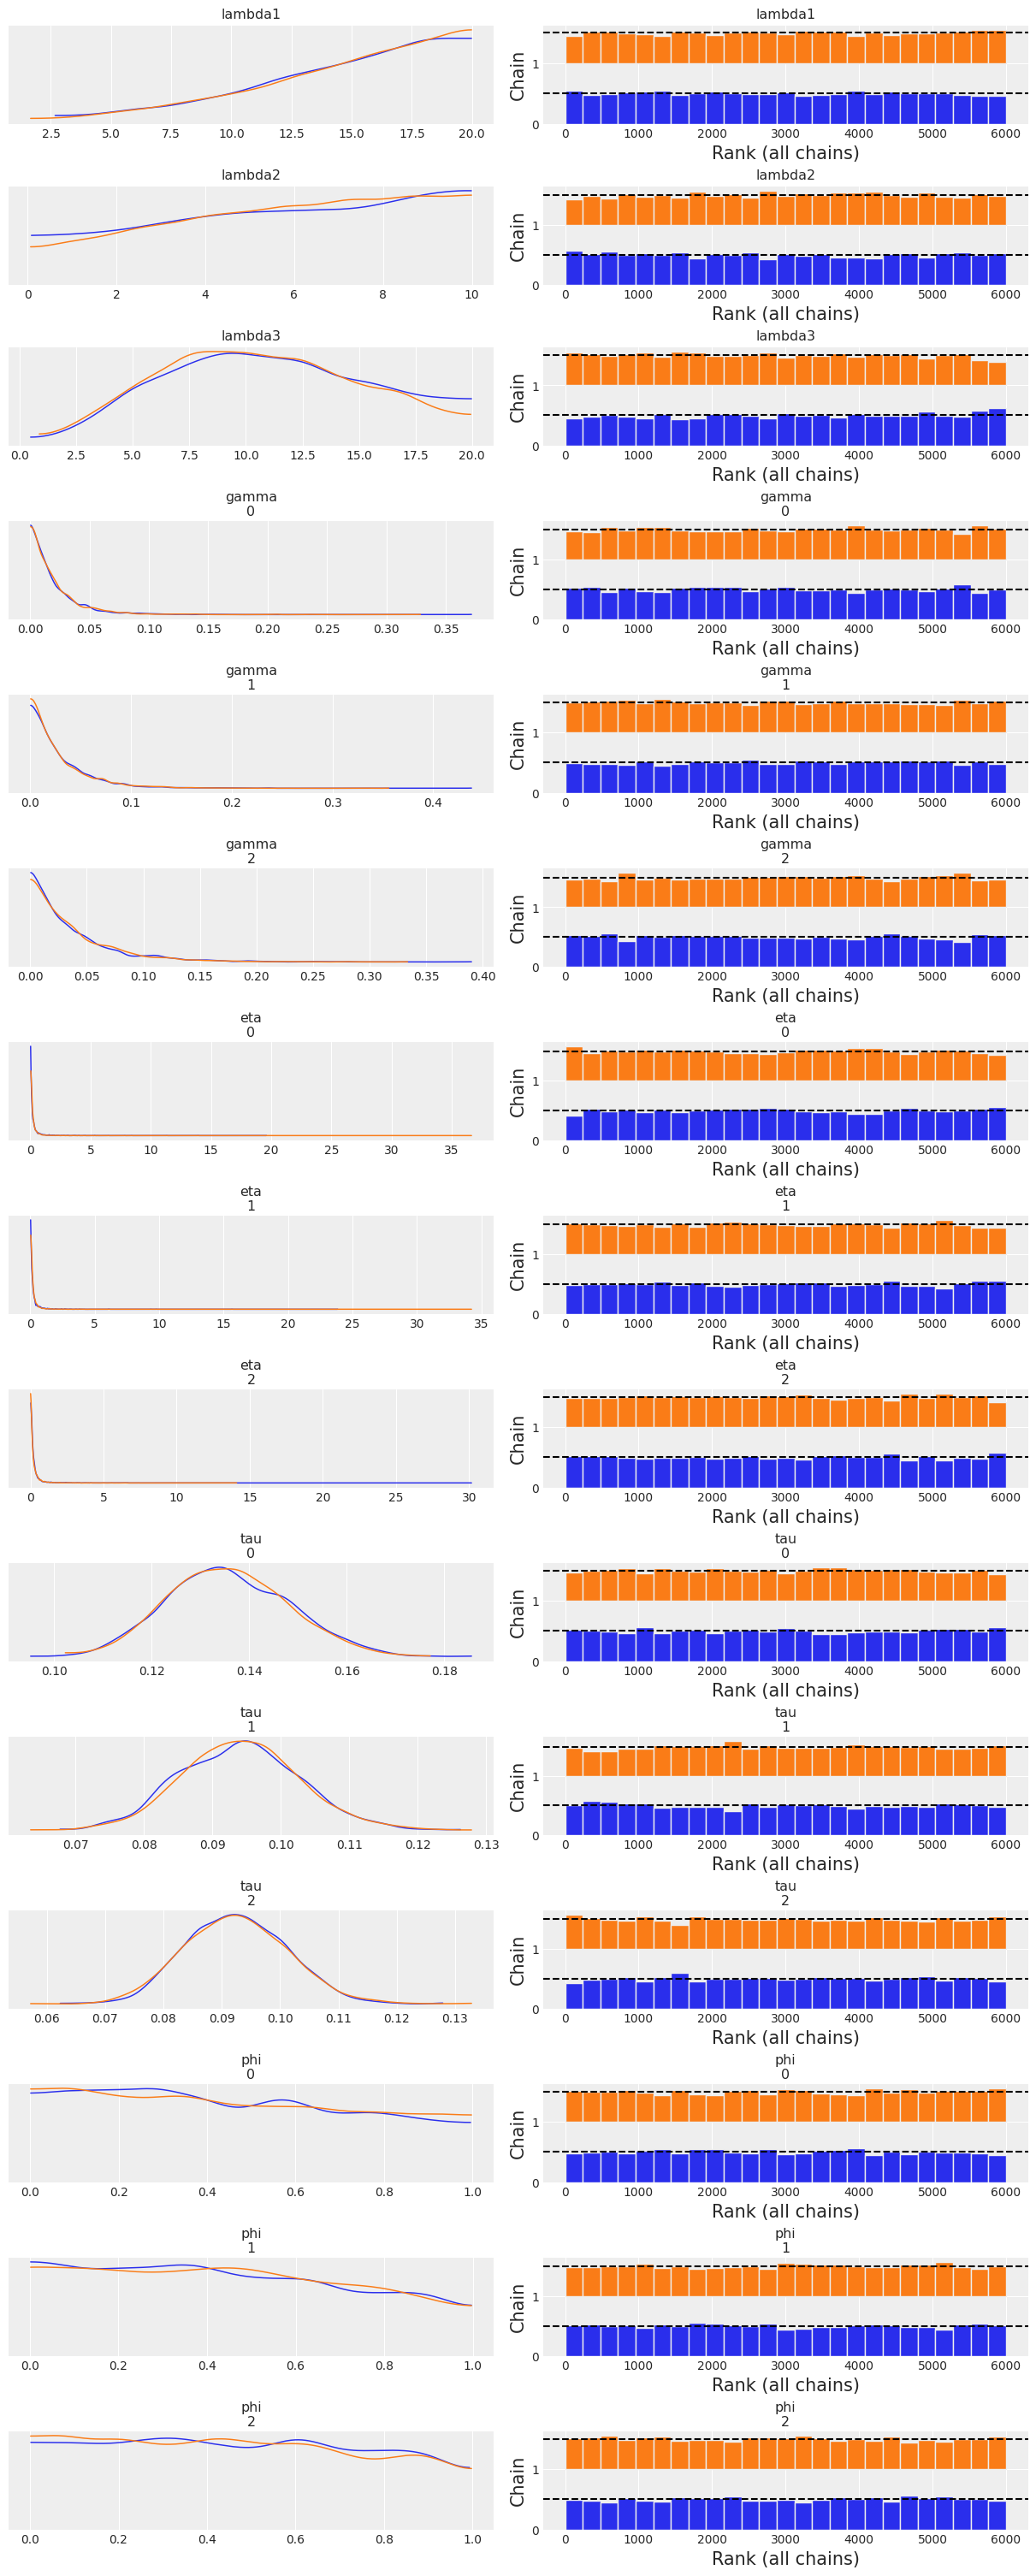

In [162]:
az.plot_trace(m8_trace, kind="rank_bars", compact=False)

# References

van Ravenzwaaij, Dutilh, Wagenmakers (2011) Cognitive model decomposition of the BART: Assessment and application, Journal of Mathematical Psychology.

Zeng, Xinglin, et al. (2023) Behavioral modeling and neuroimaging of impaired risky decision making in patients with chronic musculoskeletal pain, Neurophotonics.